# 6 予測の理由を考える〜SHapley Additive exPlanations〜

In [ ]:
#SHAPとは
#https://www.datarobot.com/jp/blog/explain-machine-learning-models-using-shap/

In [18]:
import sys
import warnings
from dataclasses import dataclass
from typing import Any  # 型ヒント用
from __future__ import annotations  # 型ヒント用

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib  # matplotlibの日本語表示対応

# 自作モジュール
sys.path.append("..")
from mli.visualize import get_visualization_setting

np.random.seed(42)
pd.options.display.float_format = "{:.2f}".format
sns.set(**get_visualization_setting())
warnings.simplefilter("ignore")  # warningsを非表示に

In [19]:
from sklearn.model_selection import train_test_split

#特徴量X1は目的変数Yに影響を与えるが特徴量X0は全く影響を与えないという設定でシュミレーションをする

def generate_simulation_data():
    """シミュレーションデータを生成し、訓練データとテストデータに分割する"""
    
    # シミュレーションの設定
    N = 1000
    J = 2
    beta = np.array([0, 1])

    # 特徴量とノイズは正規分布から生成
    X = np.random.normal(0, 1, [N, J])
    e = np.random.normal(0, 0.1, N)
    
    # 線形和で目的変数を作成
    y = X @ beta + e
    
    return train_test_split(X, y, test_size=0.2, random_state=42)
    

# シミュレーションデータを生成
X_train, X_test, y_train, y_test = generate_simulation_data()

In [20]:
from sklearn.ensemble import RandomForestRegressor
from mli.metrics import regression_metrics  # 2.3節で作成した精度評価関数


# Random Forestで予測モデルを構築
rf = RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

# 予測精度の評価
regression_metrics(rf, X_test, y_test)

,RMSE,R2
0,0.11,0.99


In [21]:
#インスタンスごとの予測値と全体での予測の平均を確認する

# 目的変数と予測値のデータフレームをつくる
df = pd.DataFrame(data=X_test, columns=["X0", "X1"])

# インスタンスごとの予測値
df["y_pred"] = rf.predict(X_test)

# ベースラインとしての予測の平均
df["y_pred_baseline"] = rf.predict(X_test).mean()

# データフレームを出力
df.head()

#インスタンス1は予測値0.68とベースライン0.05の間に0.63の差がある

,X0,X1,y_pred,y_pred_baseline
0,1.08,-0.04,0.08,0.05
1,-0.78,0.65,0.68,0.05
2,0.72,-0.37,-0.44,0.05
3,0.06,0.53,0.45,0.05
4,2.30,-0.36,-0.36,0.05


In [22]:
#SHAPを用いて、特徴量の貢献度に分解して確認していく
#特徴量が2つしかないので、以下の四通り
# インスタンス1を抽出
x = X_test[1]

# CASE1: X0もX1も分かっていないときの予測値（予測の平均）
E_baseline = rf.predict(X_test).mean()

# CASE2: X0のみが分かっているときの予測値
# 全データのX0の値をインスタンス1のX0の値に置き換えて予測を行い、平均する
X0 = X_test.copy()
X0[:, 0] = x[0]
E0 = rf.predict(X0).mean()

# CASE3: X1のみが分かっているときの予測値
# 全データのX1の値をインスタンス1のX1の値に置き換えて予測を行い、平均する
X1 = X_test.copy()
X1[:, 1] = x[1]
E1 = rf.predict(X1).mean()

# CASE4: X1もX2も分かっているときの予測値
E_full = rf.predict(x[np.newaxis, :])[0]

# 結果を出力
print(f"CASE1: X0もX1も分かっていないときの予測値 -> {E_baseline: .2f}")
print(f"CASE2: X0のみが分かっているときの予測値 -> {E0: .2f}")
print(f"CASE3: X1のみが分かっているときの予測値 -> {E1: .2f}")
print(f"CASE4: X1もX2も分かっているときの予測値 -> {E_full: .2f}")

CASE1: X0もX1も分かっていないときの予測値 ->  0.05
CASE2: X0のみが分かっているときの予測値 ->  0.05
CASE3: X1のみが分かっているときの予測値 ->  0.65
CASE4: X1もX2も分かっているときの予測値 ->  0.68


In [23]:
#SHAP値は限界貢献度を平均することで求める
#X1,0の限界貢献度がX1,0がわかったときにどれくらい予測値が変化するかで求めることができる
#CASE2-Case1とCASE4-CASE3の平均したものがSAHP値となる
SHAP0 = ((E0 - E_baseline) + (E_full - E1)) / 2

#X1,1も同様
SHAP1 = ((E1 - E_baseline) + (E_full - E0)) / 2

print(f"(SHAP0, SHAP1) = {SHAP0:.2f}, {SHAP1:.2f}")

#X1,0の貢献度0,02とX1,1の貢献度0.62に分解できる

(SHAP0, SHAP1) = 0.02, 0.62


In [24]:
from scipy.special import factorial
from itertools import combinations


@dataclass
class ShapleyAdditiveExplanations:
    """SHapley Additive exPlanations
    
    Args:
        estimator: 学習済みモデル
        X: SHAPの計算に使う特徴量
        var_names: 特徴量の名前
    """
    
    estimator: Any
    X: np.ndarray
    var_names: list[str]
        
    def __post_init__(self) -> None:
        # ベースラインとしての平均的な予測値
        self.baseline = self.estimator.predict(self.X).mean()

        # 特徴量の総数
        self.J = self.X.shape[1]

        # あり得るすべての特徴量の組み合わせ
        self.subsets = [
            s
            for j in range(self.J + 1)
            for s in combinations(range(self.J), j)
        ]

    def _get_expected_value(self, subset: tuple[int, ...]) -> np.ndarray:
        """特徴量の組み合わせを指定するとその特徴量が場合の予測値を計算

        Args:
            subset: 特徴量の組み合わせ
        """
        
        _X = self.X.copy()  # 元のデータが上書きされないように

        # 特徴量がある場合は上書き。なければそのまま。
        if subset is not None:
            # 元がtupleなのでリストにしないとインデックスとして使えない
            _s = list(subset)
            _X[:, _s] = _X[self.i, _s]

        return self.estimator.predict(_X).mean()

    def _calc_weighted_marginal_contribution(
        self,
        j: int,
        s_union_j: tuple[int, ...]
    ) -> float:
        """限界貢献度x組み合わせ出現回数を求める

        Args:
            j: 限界貢献度を計算したい特徴量のインデックス
            s_union_j: jを含む特徴量の組み合わせ
        """
        
        # 特徴量jがない場合の組み合わせ
        s = tuple(set(s_union_j) - set([j]))

        # 組み合わせの数
        S = len(s)

        # 組み合わせの出現回数
        # ここでfactorial(self.J)で割ってしまうと丸め誤差が出てるので、あとで割る
        weight = factorial(S) * factorial(self.J - S - 1)

        # 限界貢献度
        marginal_contribution = (
            self.expected_values[s_union_j] - self.expected_values[s]
        )

        return weight * marginal_contribution

    def shapley_additive_explanations(self, id_to_compute: int) -> None:
        """SHAP値を求める

        Args:
            id_to_compute: SHAPを計算したいインスタンス
        """

        # SHAPを計算したいインスタンス
        self.i = id_to_compute

        # すべての組み合わせに対して予測値を計算
        # 先に計算しておくことで同じ予測を繰り返さずに済む
        self.expected_values = {
            s: self._get_expected_value(s) for s in self.subsets
        }

        # ひとつひとつの特徴量に対するSHAP値を計算
        shap_values = np.zeros(self.J)
        for j in range(self.J):
            # 限界貢献度の加重平均を求める
            # 特徴量jが含まれる組み合わせを全部もってきて
            # 特徴量jがない場合の予測値との差分を見る
            shap_values[j] = np.sum([
                self._calc_weighted_marginal_contribution(j, s_union_j)
                for s_union_j in self.subsets
                if j in s_union_j
            ]) / factorial(self.J)
        
        # データフレームとしてまとめる
        self.df_shap = pd.DataFrame(
            data={
                "var_name": self.var_names,
                "feature_value": self.X[id_to_compute],
                "shap_value": shap_values,
            }
        )

    def plot(self) -> None:
        """SHAPを可視化"""
        
        # 下のデータフレームを書き換えないようコピー
        df = self.df_shap.copy()
        
        # グラフ用のラベルを作成
        df['label'] = [
            f"{x} = {y:.2f}" for x, y in zip(df.var_name, df.feature_value)
        ]
        
        # SHAP値が高い順に並べ替え
        df = df.sort_values("shap_value").reset_index(drop=True)
        
        # 全特徴量の値がときの予測値
        predicted_value = self.expected_values[self.subsets[-1]]
        
        # 棒グラフを可視化
        fig, ax = plt.subplots()
        ax.barh(df.label, df.shap_value)
        ax.set(xlabel="SHAP値", ylabel=None)
        fig.suptitle(f"SHAP値 \n(Baseline: {self.baseline:.2f}, Prediction: {predicted_value:.2f}, Difference: {predicted_value - self.baseline:.2f})")

        fig.show()

In [25]:
# SHAPのインスタンスを作成
shap = ShapleyAdditiveExplanations(rf, X_test, ["X0", "X1"])

# インスタンス1に対してSHAP値を計算
shap.shapley_additive_explanations(id_to_compute=1)

# SHAP値を出力
shap.df_shap

,var_name,feature_value,shap_value
0,X0,-0.78,0.02
1,X1,0.65,0.62


In [26]:
# A, B, Cから2つを選ぶ組み合わせ
list(combinations(["A", "B", "C"], 2))

[('A', 'B'), ('A', 'C'), ('B', 'C')]

In [27]:
# 特徴量X0、X1の分かっている組み合わせ
shap.subsets

[(), (0,), (1,), (0, 1)]

In [28]:
# 特定の特徴量が分かっている場合の予測値を計算
{s: shap._get_expected_value(s) for s in shap.subsets}

{(): 0.04796005415639935,
 (0,): 0.05378333975662723,
 (1,): 0.6519497702656634,
 (0, 1): 0.6849473377476549}

In [29]:
# 特徴量X1に対するSHAP値を計算
j = 1
np.sum([
    shap._calc_weighted_marginal_contribution(j, s_union_j)
    for s_union_j in shap.subsets
    if j in s_union_j
]) / factorial(shap.J)

0.6175768570501459

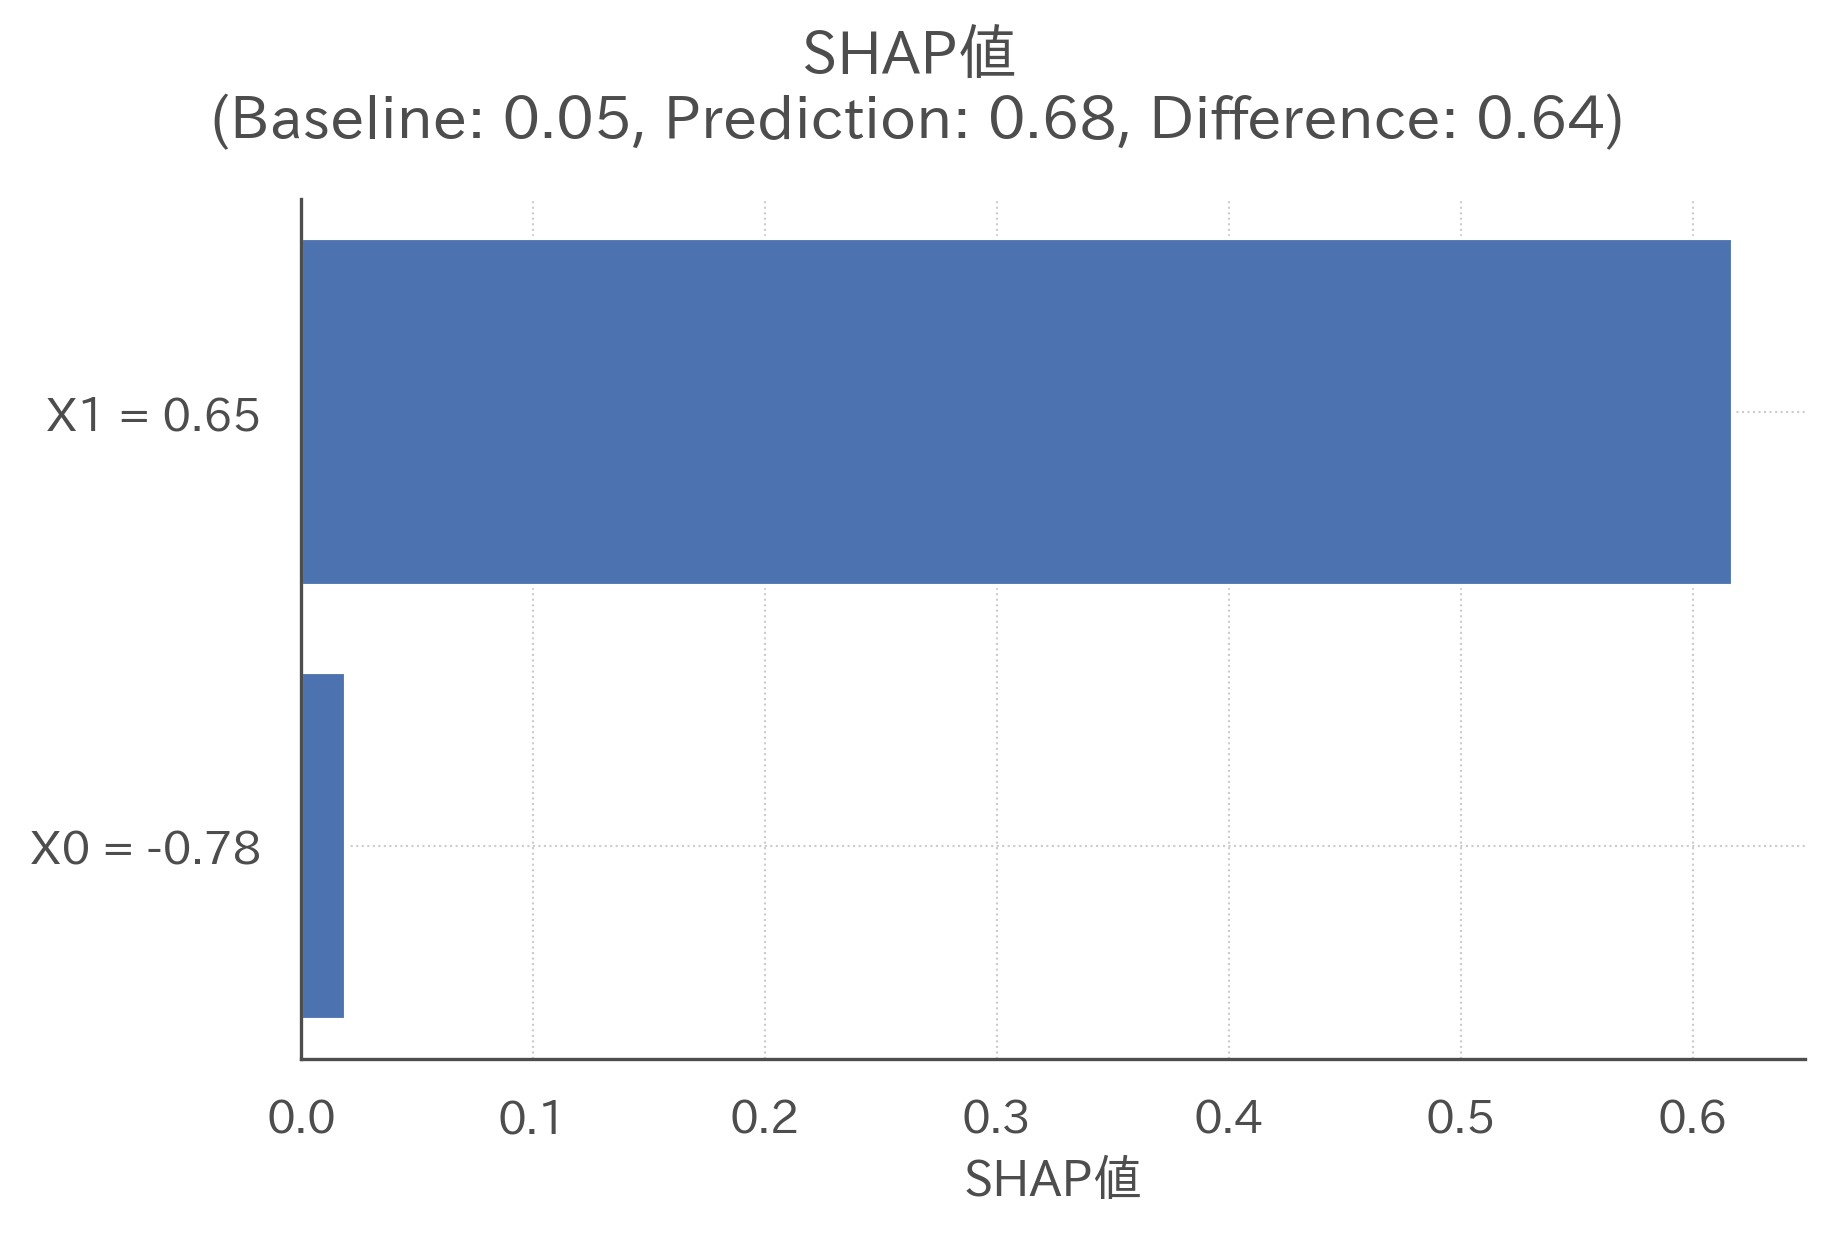

In [30]:
# SHAP値を計算
shap.shapley_additive_explanations(id_to_compute=1)

# SHAP値を可視化
shap.plot()

#予測値とベースラインの差分が0.64
#X1,0 = ^-0.78のほぼゼロの貢献度とX1,1 = ^0.65の約0.6の貢献度に分解できる

In [31]:
import joblib


# データと学習済みモデルを読み込む
X_train, X_test, y_train, y_test = joblib.load("../data/boston_housing.pkl")
rf = joblib.load("../model/boston_housing_rf.pkl")

In [33]:
import shap


# SHAP値を計算するためのexplainerを作成
explainer = shap.TreeExplainer(
    model=rf,  # 学習済みモデル
    data=X_test,  # SHAPを計算するためのデータ
    feature_perturbation="interventional",  # 推奨
)

In [34]:
# SHAP値を計算
shap_values = explainer(X_test)

In [35]:
# インスタンス0の情報。表示されていないが変数名なども格納されている
shap_values[0]

.values =
array([ 0.44924819,  0.0064612 , -0.07374332, -0.0059334 ,  0.24057655,
       -0.75573828, -0.21184274,  0.07854384,  0.02089209,  0.10778563,
        0.33532324,  0.02934682,  1.26302041])

.base_values =
21.353500000000007

.data =
array([9.1780e-02, 0.0000e+00, 4.0500e+00, 0.0000e+00, 5.1000e-01,
       6.4160e+00, 8.4100e+01, 2.6463e+00, 5.0000e+00, 2.9600e+02,
       1.6600e+01, 3.9550e+02, 9.0400e+00])

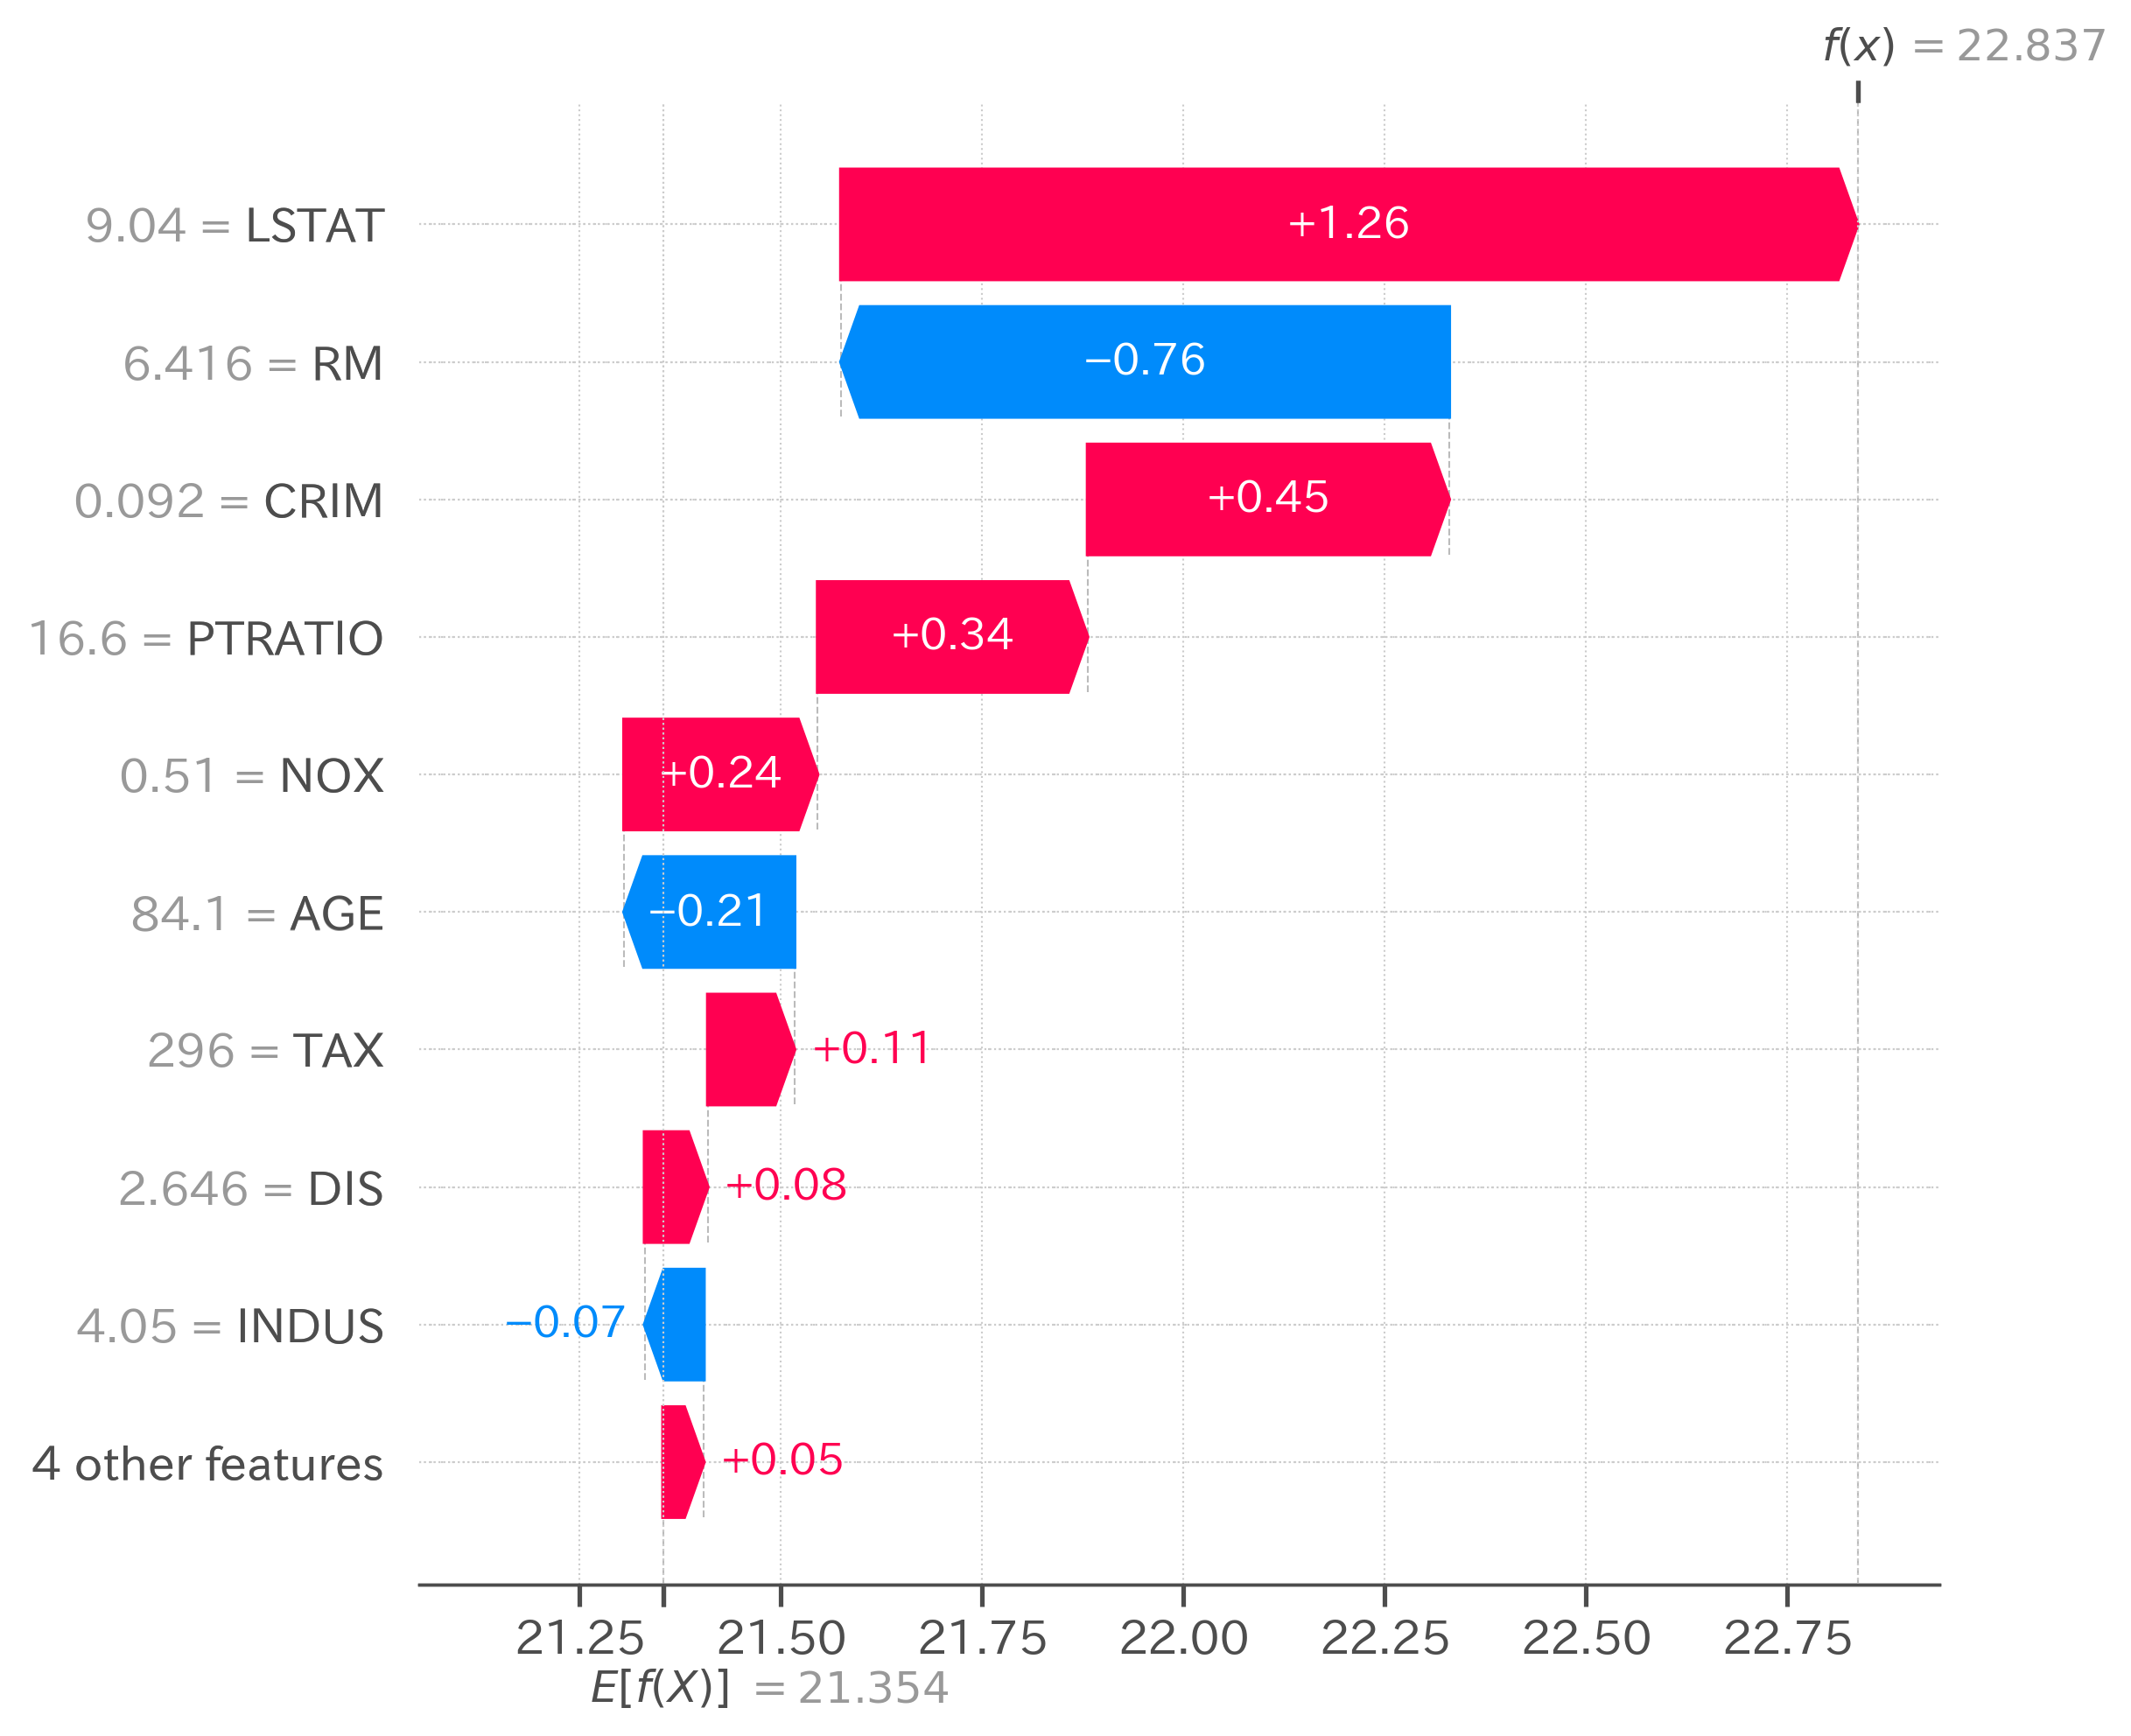

In [36]:
# インスタンス0のSHAP値を可視化
shap.plots.waterfall(shap_values[0])

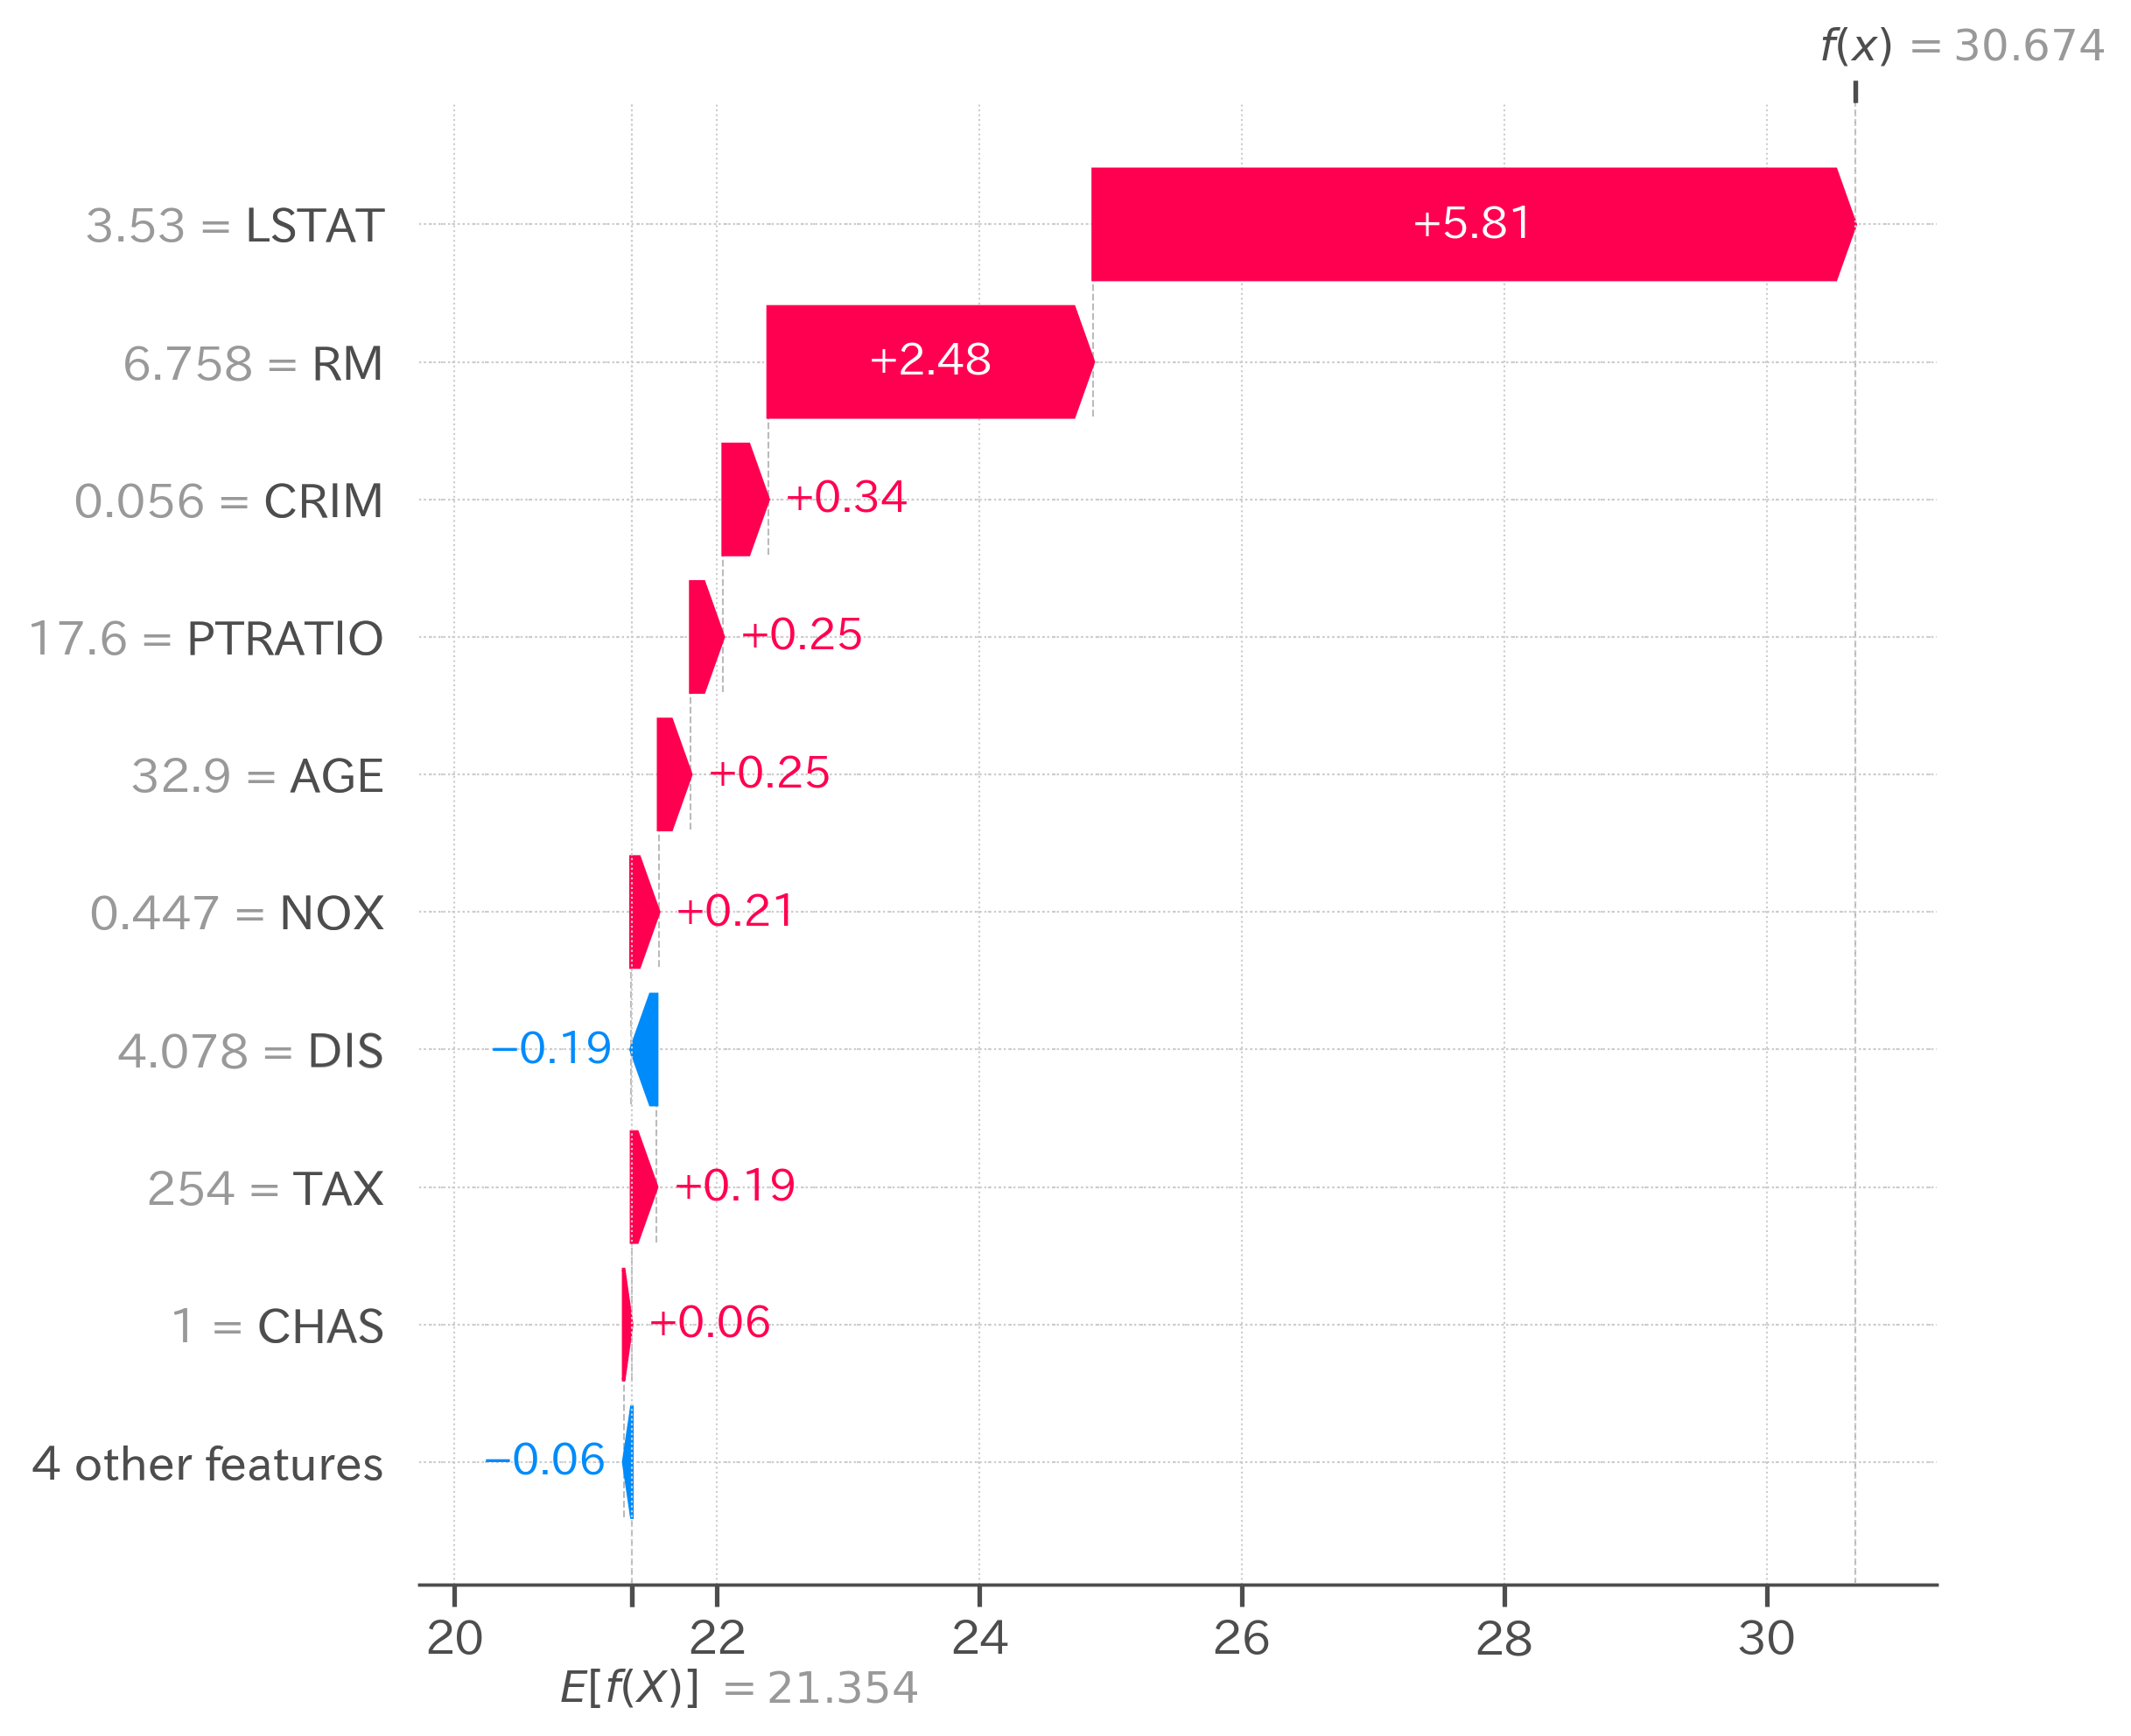

In [37]:
# インスタンス1のSHAP値を可視化
shap.waterfall_plot(shap_values[1])

In [ ]:
#SHAPはひとつひとつのインスタンスの予測値の理由を解釈するミクロな解釈手法
#でも、適当な粒度での集計や可視化を行うことで、マクロな解釈手法としても利用できる

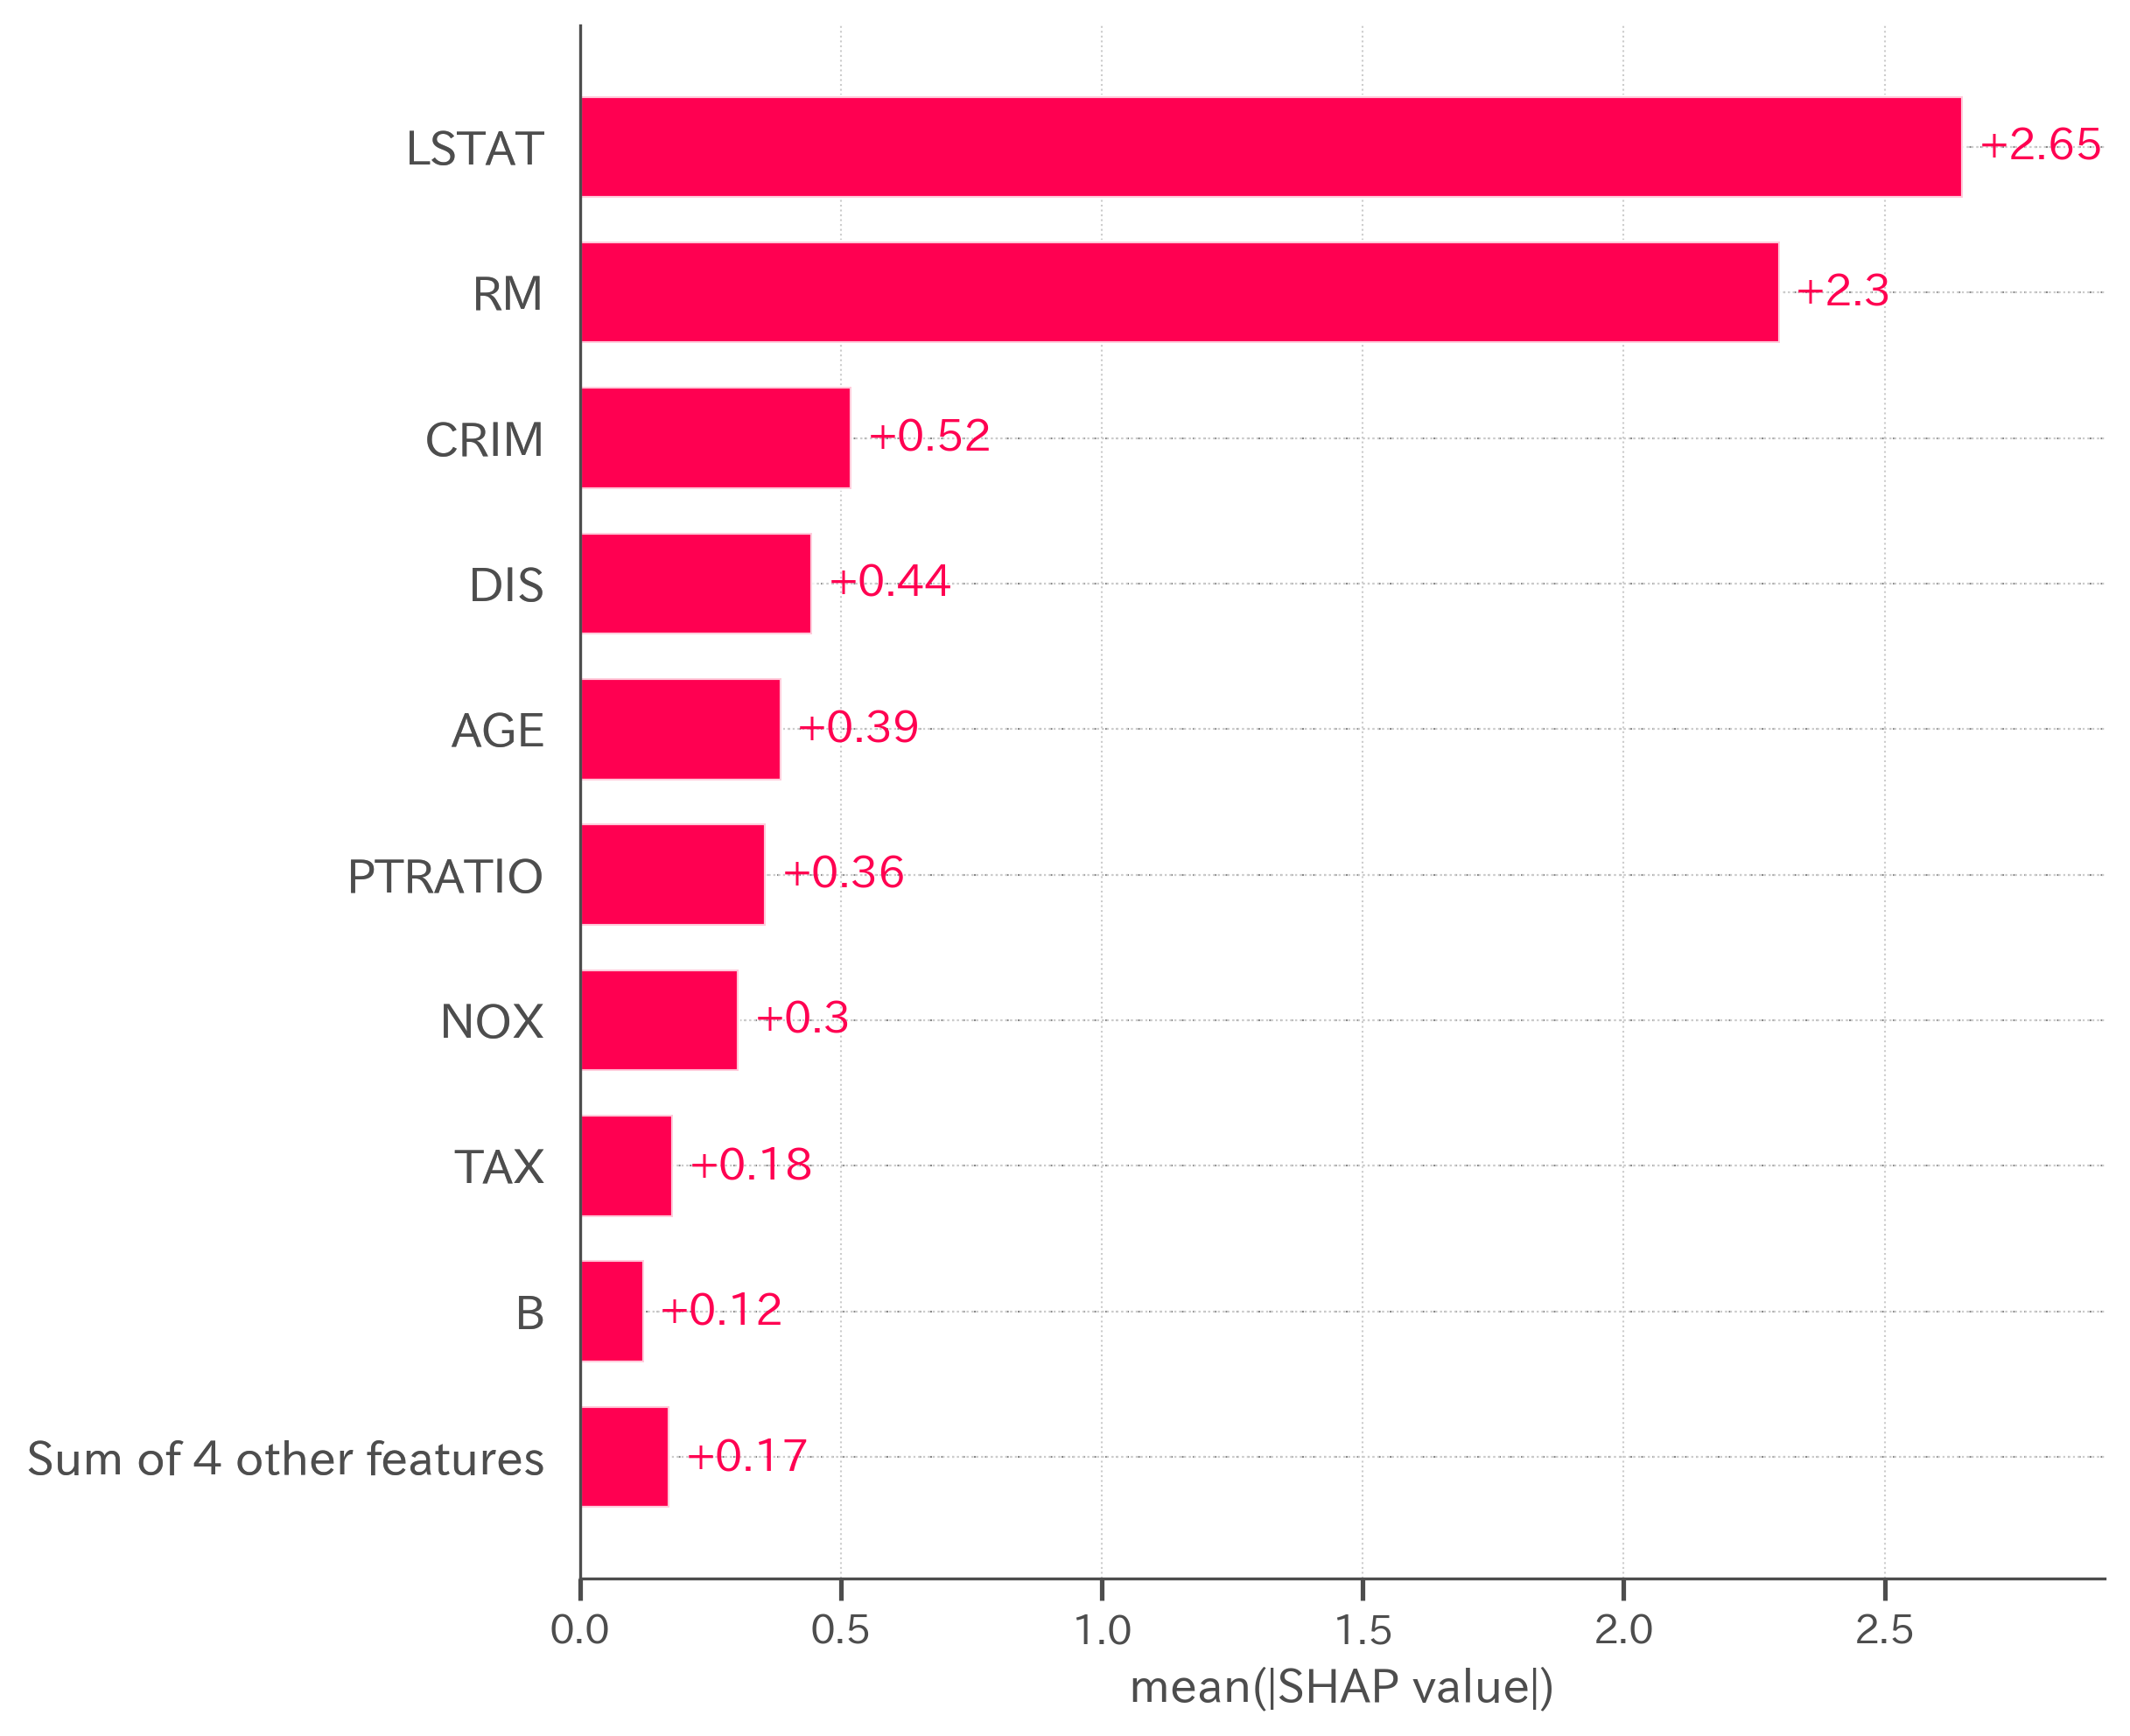

In [38]:
#平均的な重要度の可視化
# 棒グラフで重要度を可視化
shap.plots.bar(shap_values=shap_values)

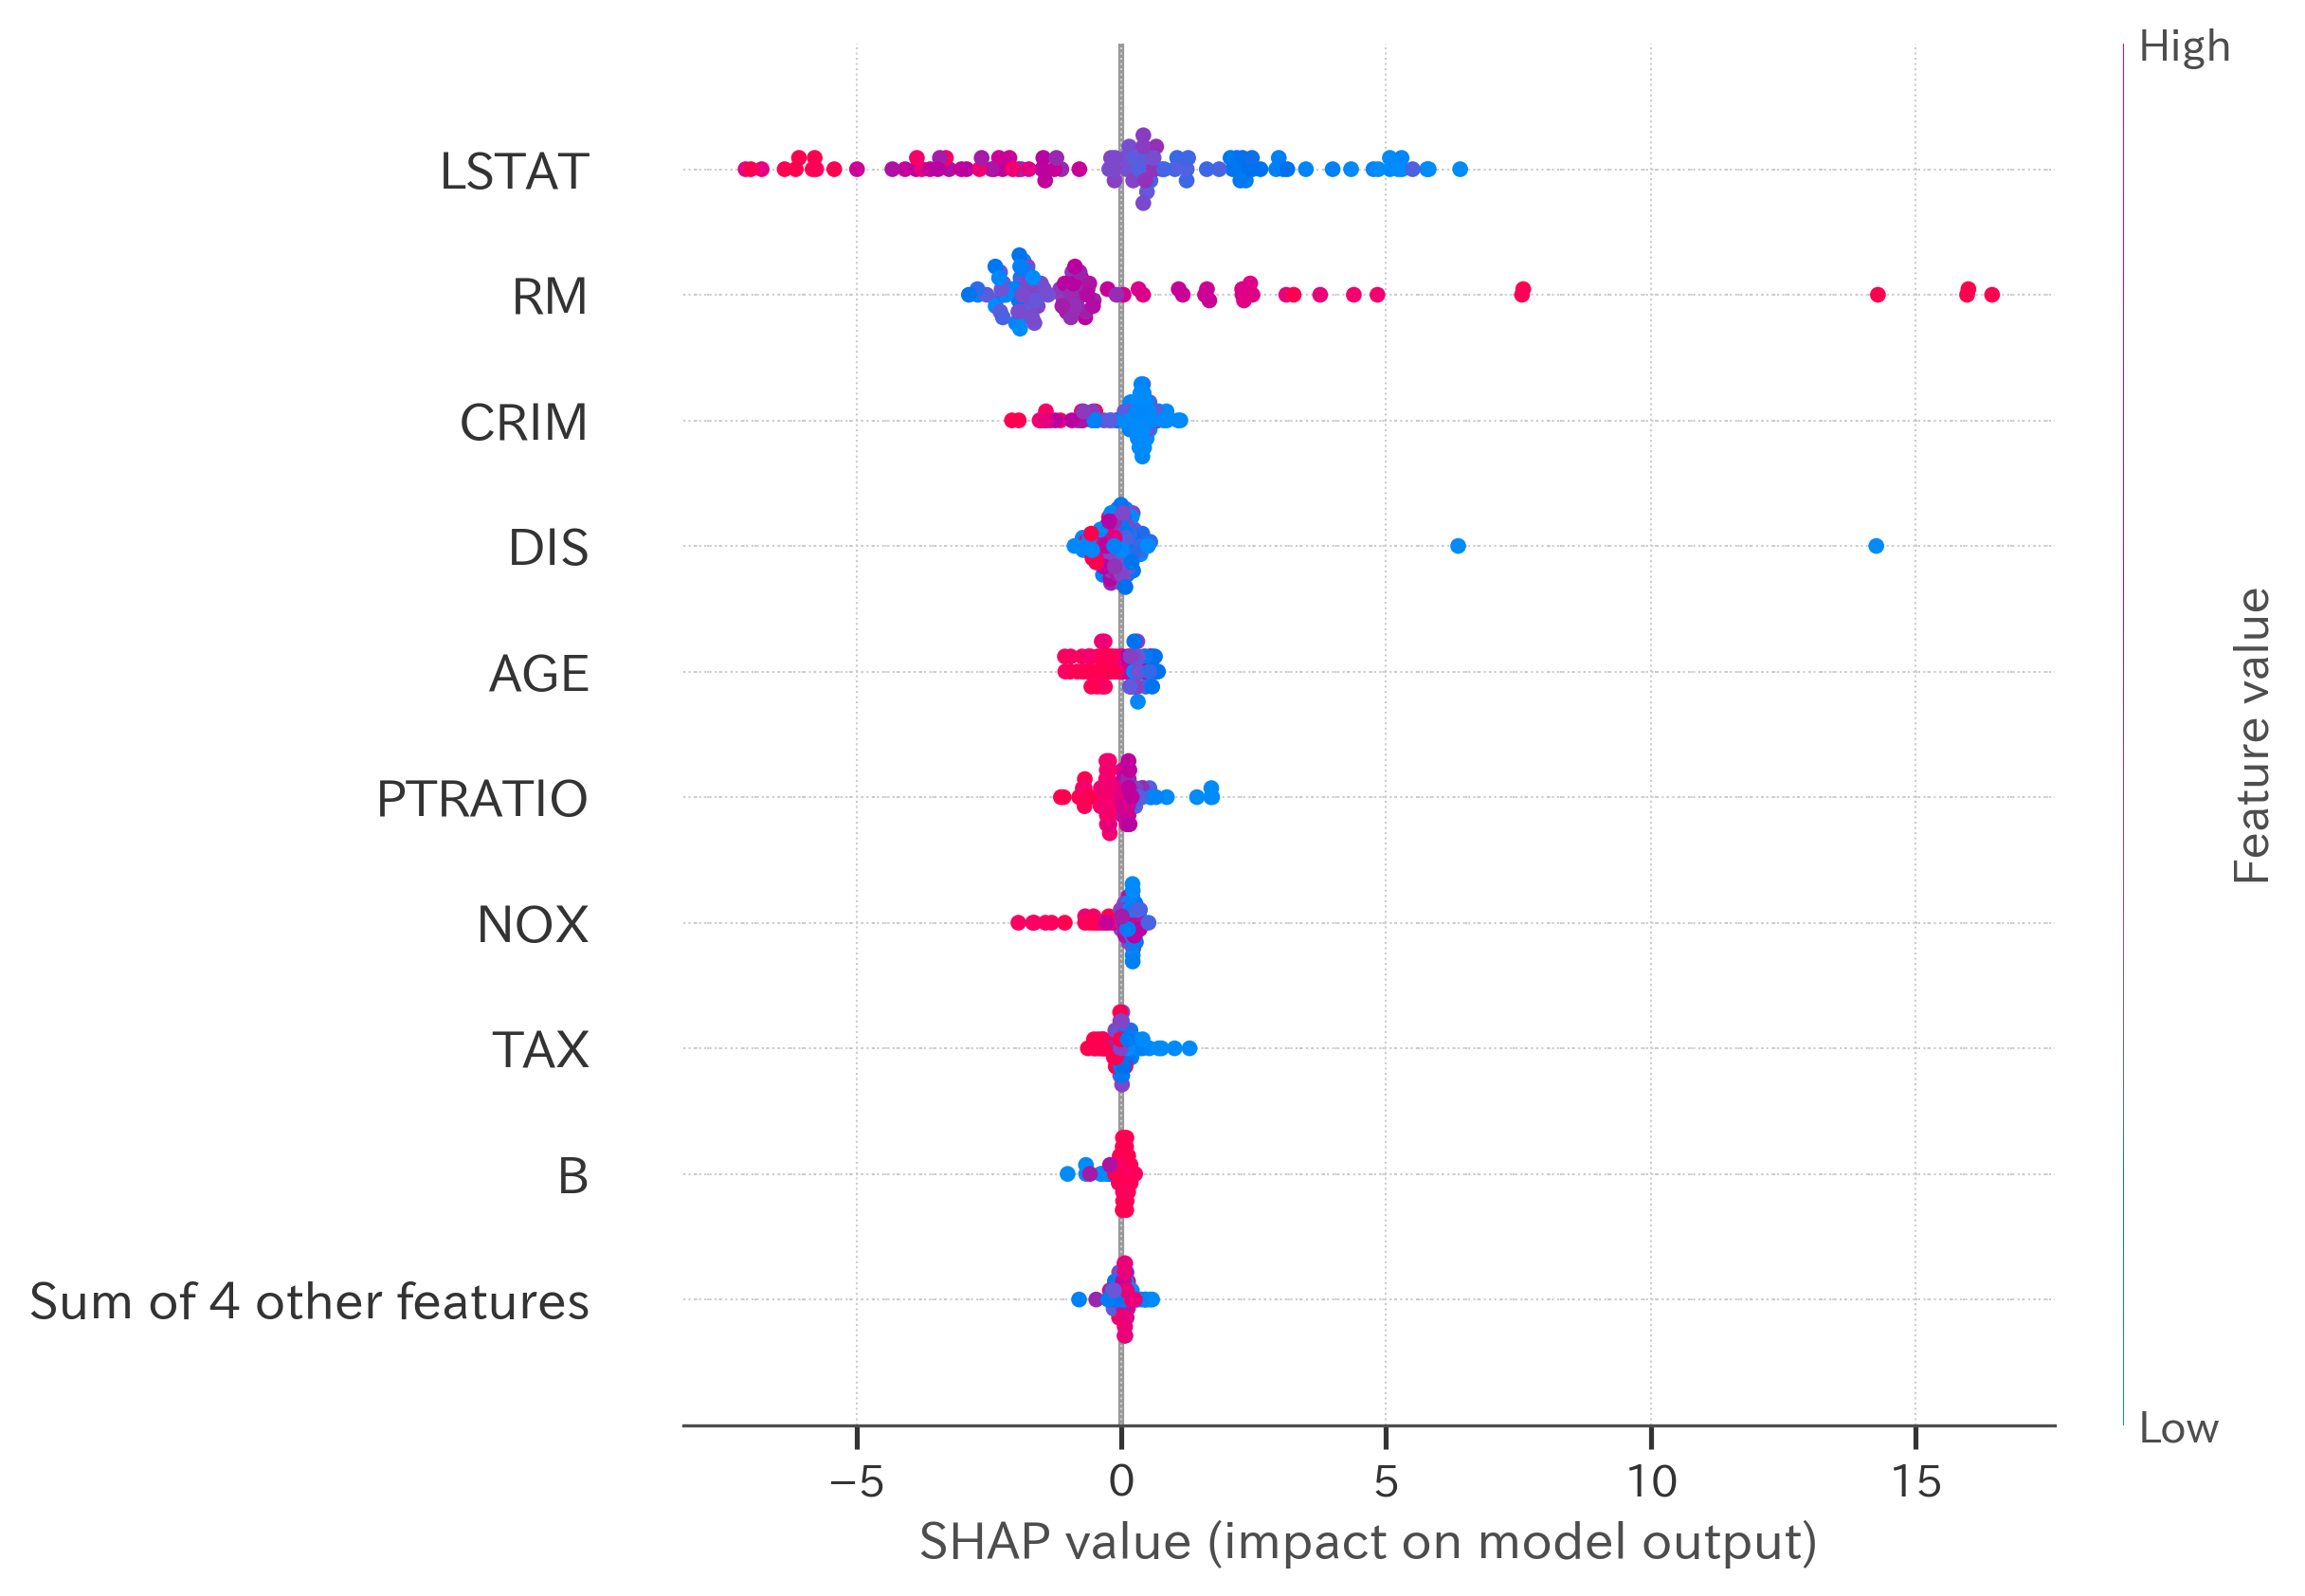

In [21]:
#貢献度の分布を確認
# beeswarm plotで重要度を可視化
shap.plots.beeswarm(shap_values)

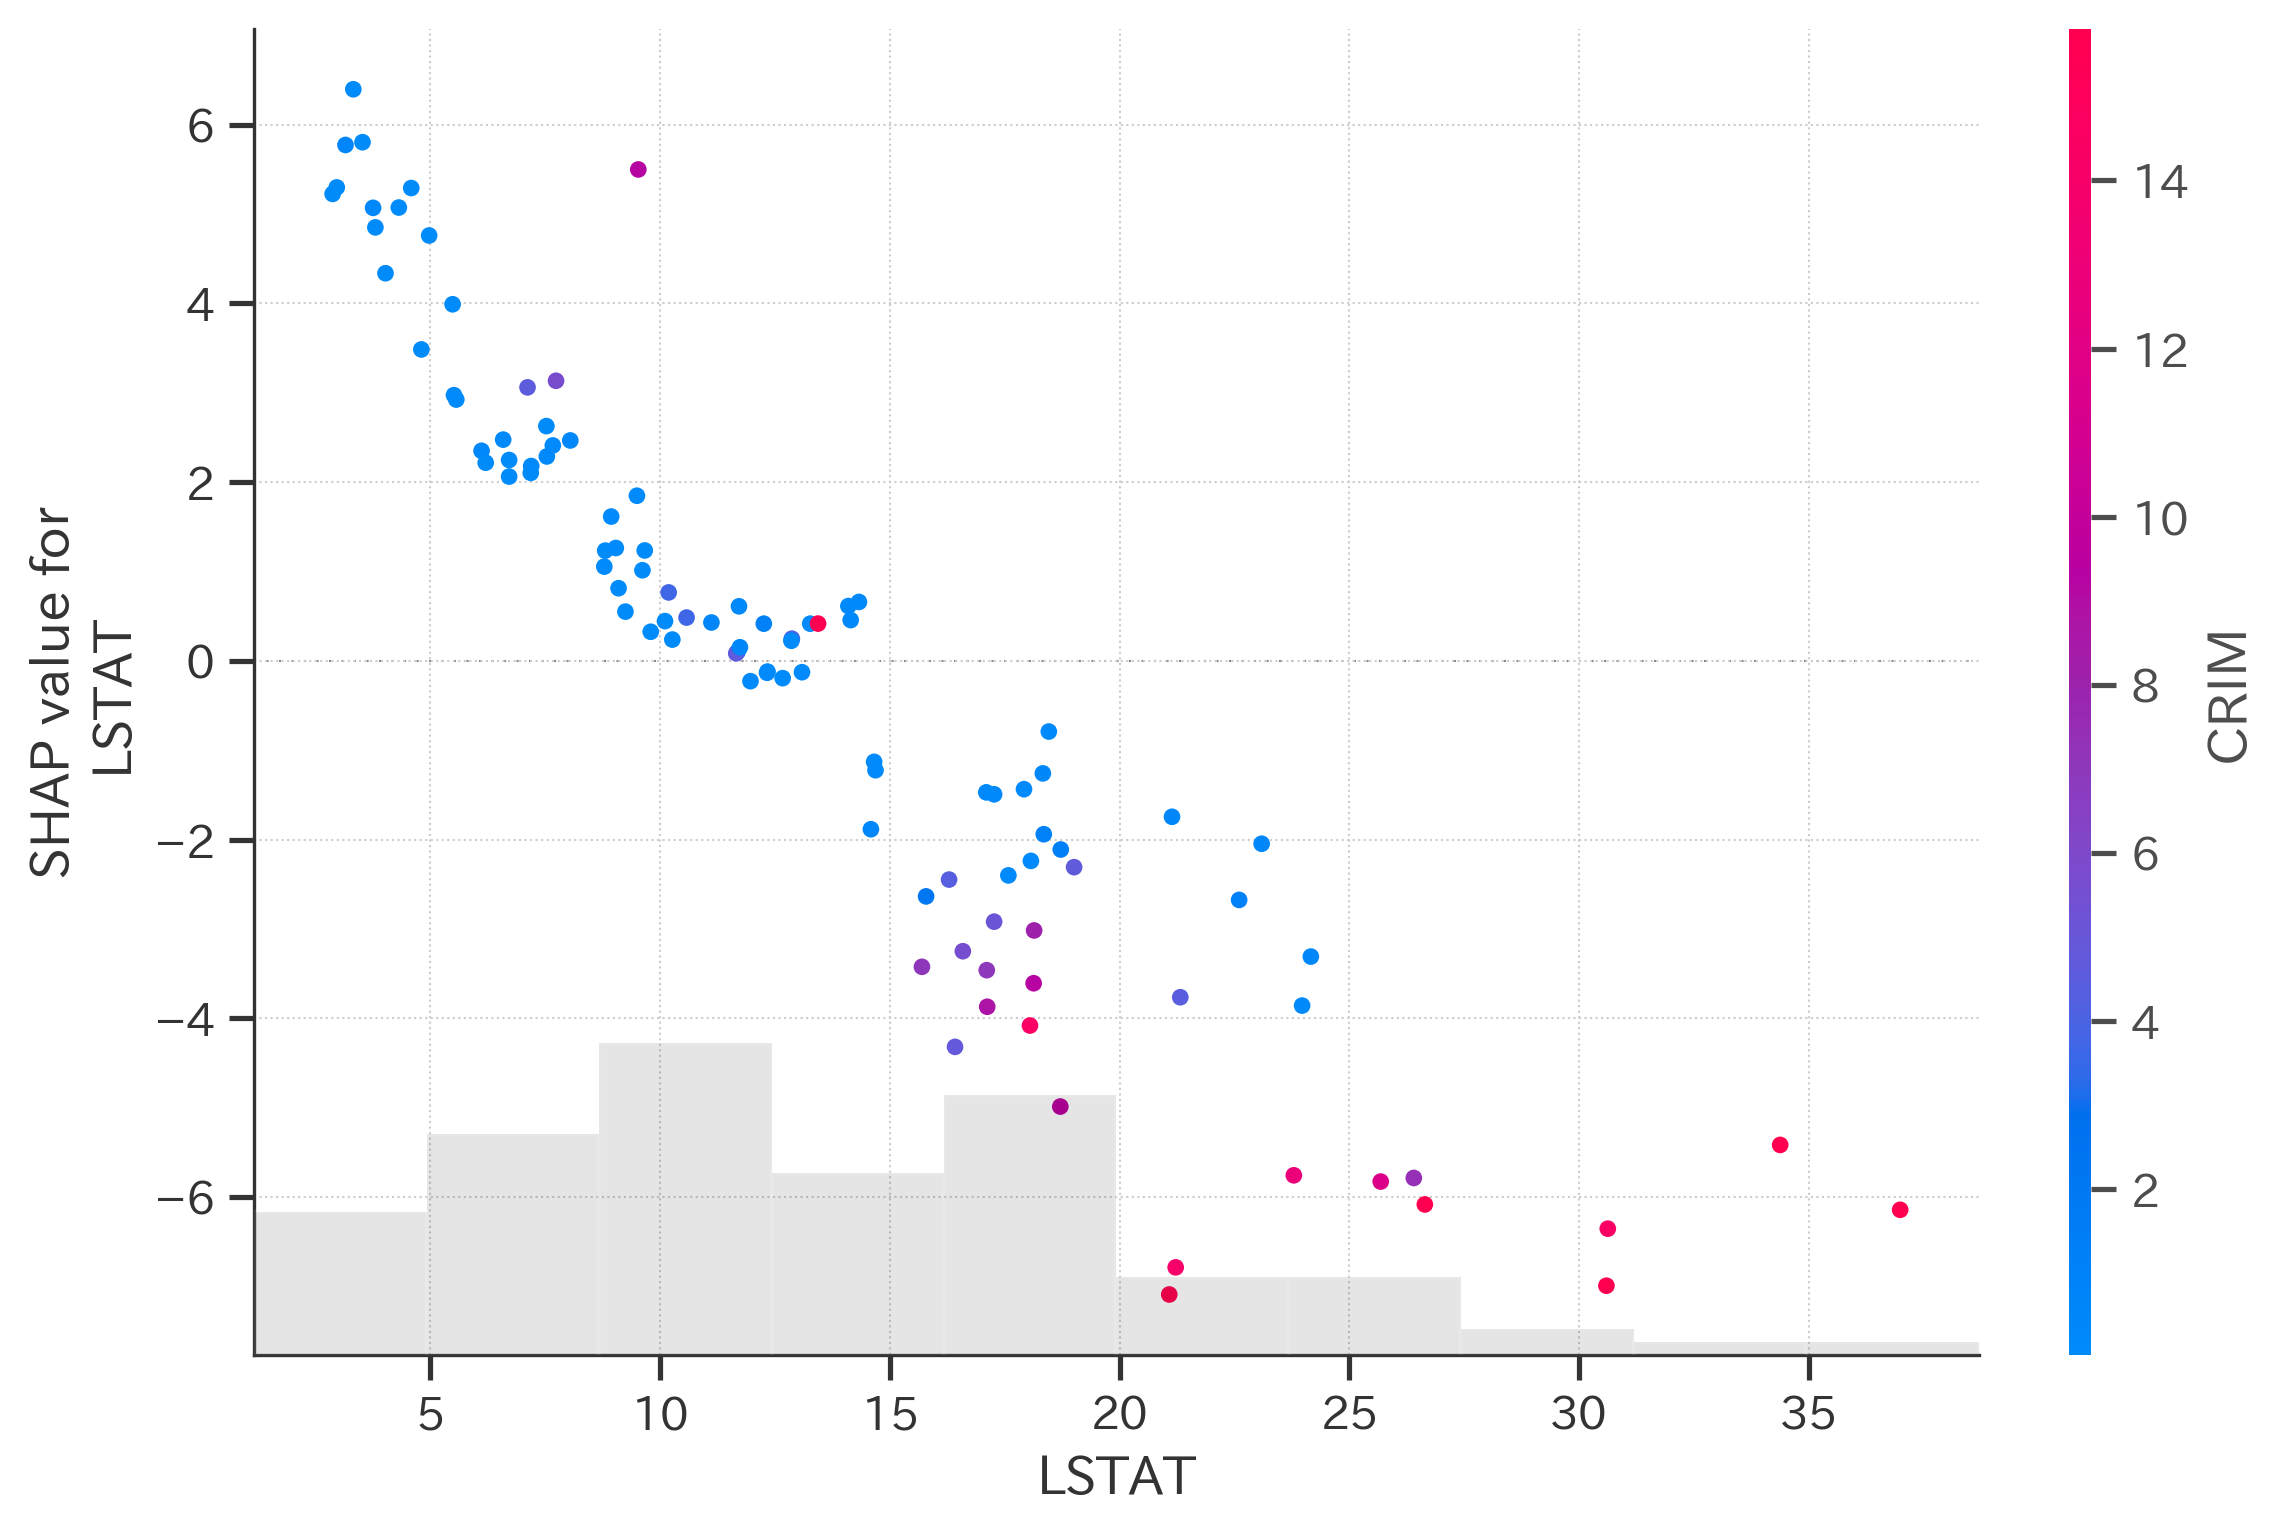

In [39]:
# SHAPによるPDを可視化
shap.plots.scatter(shap_values[:, "LSTAT"], color=shap_values)

#低所得者の割合が高いほどSHAP値は下がる
#強い交互作用を持つ特徴量を自動で選択して色で表示（CRIM）、CRIMが高いほどLSTATの貢献度が強くマイナスになる

In [40]:
#X2=1のときX1は目的変数と正の関係があり、X2=0のときはX1は目的変数と負の関係がある
def generate_simulation_data():
    """シミュレーションデータを生成し、訓練データとテストデータに分割"""
    
    # シミュレーションの設定
    N = 1000
    
    # X0とX1は一様分布から生成
    x0 = np.random.uniform(-1, 1, N)
    x1 = np.random.uniform(-1, 1, N)
    # 二項分布の試行回数を1にすると成功確率0.5のベルヌーイ分布と一致
    x2 = np.random.binomial(1, 0.5, N)
    # ノイズは正規分布からデータを生成
    epsilon = np.random.normal(0, 0.1, N)
    
    # 特徴量をまとめる
    X = np.column_stack((x0, x1, x2))
    
    # 線形和で目的変数を作成
    y = x0 - 5 * x1 + 10 * x1 * x2 + epsilon

    return train_test_split(X, y, test_size=0.2, random_state=42)


# シミュレーションデータを生成
X_train, X_test, y_train, y_test = generate_simulation_data()

In [43]:
# Random Forestで予測モデルを構築
rf = RandomForestRegressor(n_jobs=-1, random_state=42).fit(X_train, y_train)

# 特徴量の名前がわかると便利なのでデータフレームにする
X_test = pd.DataFrame(X_test, columns=["X0", "X1", "X2"])

# explainerを作成
explainer = shap.TreeExplainer(rf, X_test)

# SHAP値を計算
shap_values = explainer(X_test)

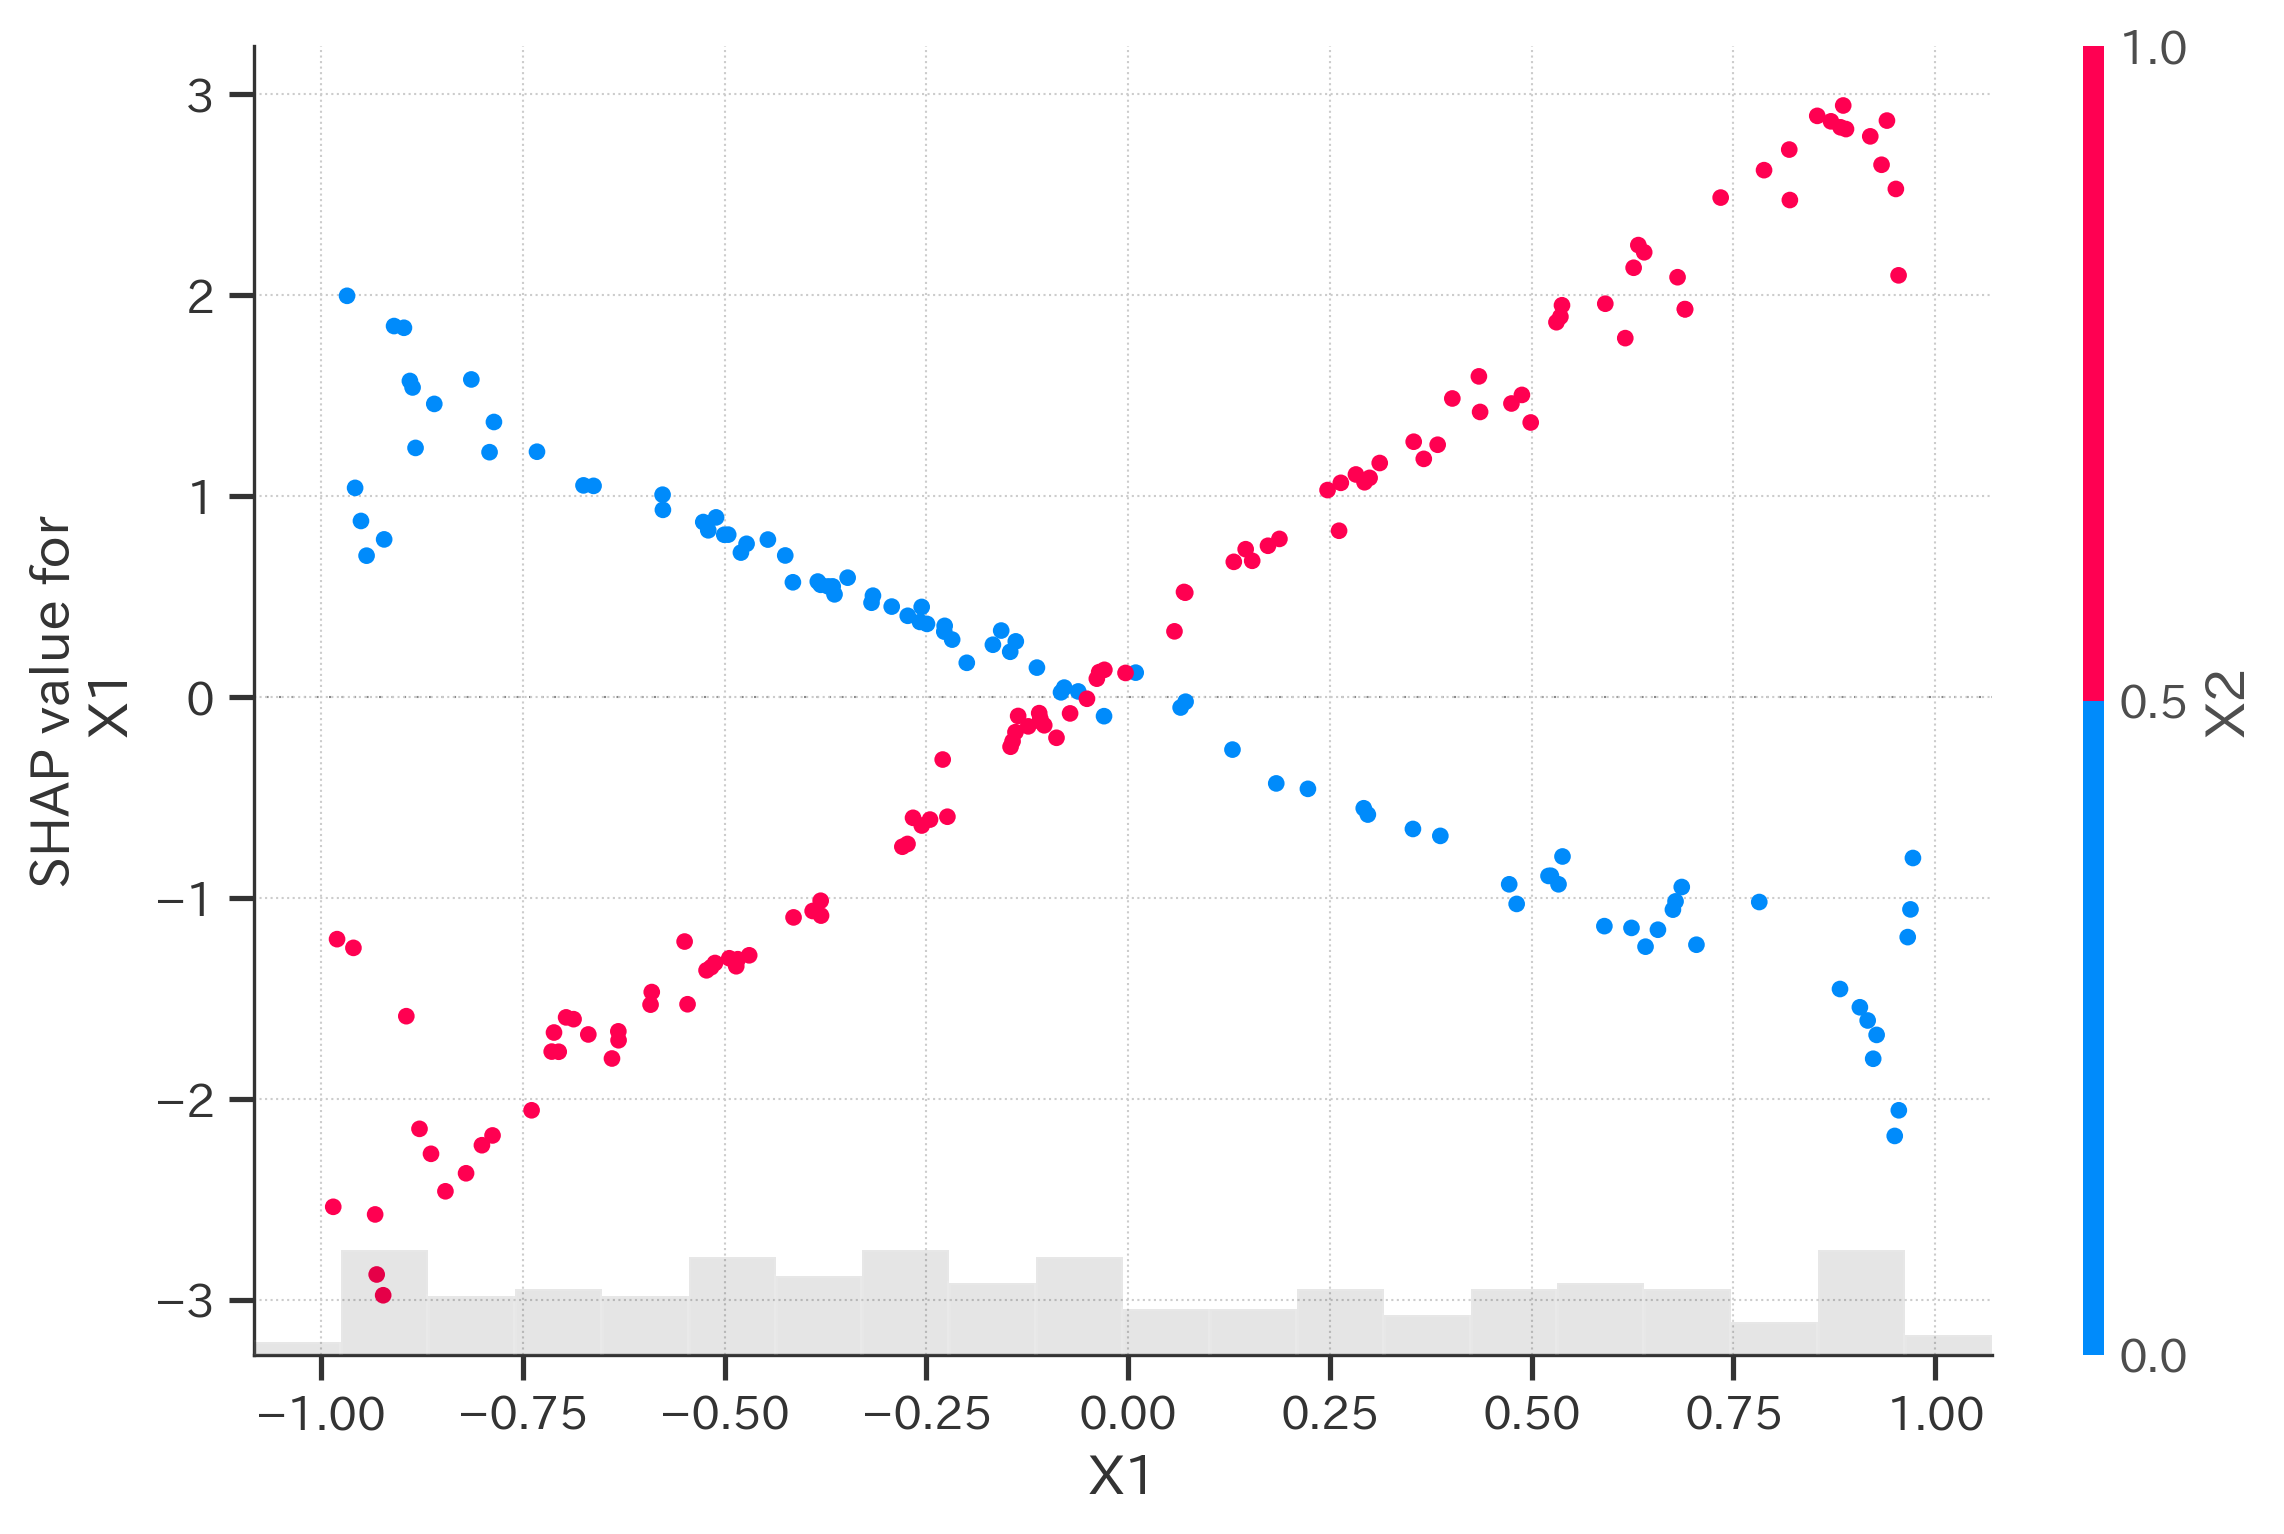

In [42]:
# SHAPによるPDを可視化
shap.plots.scatter(shap_values[:, "X1"], color=shap_values)

#X2=1のときはX1が大きくなるほどSHAP値も高くなり、X2=0のときはX1が大きくなるほどSHAP値も小さくなる